In [26]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import StandardScaler

import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# My module built with Spotify API and spotipy library
from spotify import Spotify

from sklearn.preprocessing import MinMaxScaler

# My own credenctials
from utils.config import SpotifyCredectials


Here I want to do EDA(Explanatory Data Analysis) with data which I choose one of the most famous and my favorite rock band "Oasis". 

I want to use unsupervised clustering model in upcoming pipeline to categorize their songs so I will work on EDA by keeping that in my mind. 

### Intialize Spotify API with artist Seaching Query

In [2]:
cred = SpotifyCredectials()

my_id = cred.my_id
my_secret = cred.my_secret

spotify = Spotify('Oasis', my_id, my_secret)

### Get all songs df with audio feature

In [3]:
oasis_df = spotify.all_song_feature_df

# Explanatory Data Analysis

### Explore general data information

In [4]:
oasis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 90
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              391 non-null    object 
 1   danceability      391 non-null    float64
 2   energy            391 non-null    float64
 3   key               391 non-null    int64  
 4   loudness          391 non-null    float64
 5   mode              391 non-null    int64  
 6   speechiness       391 non-null    float64
 7   acousticness      391 non-null    float64
 8   instrumentalness  391 non-null    float64
 9   liveness          391 non-null    float64
 10  valence           391 non-null    float64
 11  tempo             391 non-null    float64
 12  type              391 non-null    object 
 13  id                391 non-null    object 
 14  uri               391 non-null    object 
 15  track_href        391 non-null    object 
 16  analysis_url      391 non-null    object 
 17

Observations<br>
<li>it doens't have any missing value. </li>
<li>There are some columns which have dtype as object, so I will check if those are necessary for clustering(Probably not) </li>

In [5]:
cat_cols = oasis_df.select_dtypes(include=['object']).columns.tolist()
cat_df = oasis_df[cat_cols]
cat_df.head(3)

,name,type,id,uri,track_href,analysis_url
0,"Columbia - Live at Knebworth, 10 August '96",audio_features,4GCJnyQmXZG9nBxxTuQ9E4,spotify:track:4GCJnyQmXZG9nBxxTuQ9E4,https://api.spotify.com/v1/tracks/4GCJnyQmXZG9...,https://api.spotify.com/v1/audio-analysis/4GCJ...
1,"Acquiesce - Live at Knebworth, 10 August '96",audio_features,0VAZaVLciiPPfS0onyzRwD,spotify:track:0VAZaVLciiPPfS0onyzRwD,https://api.spotify.com/v1/tracks/0VAZaVLciiPP...,https://api.spotify.com/v1/audio-analysis/0VAZ...
2,"Supersonic - Live at Knebworth, 10 August '96",audio_features,1gzwbFfjM0VR6q9g230SBW,spotify:track:1gzwbFfjM0VR6q9g230SBW,https://api.spotify.com/v1/tracks/1gzwbFfjM0VR...,https://api.spotify.com/v1/audio-analysis/1gzw...


In [6]:
# Check number of unique value in each categorical columns 
cat_unique_df = cat_df.nunique().to_frame().T
print('df size:', len(cat_df))
cat_unique_df

df size: 391


,name,type,id,uri,track_href,analysis_url
0,216,1,391,391,391,391


Observations<br>
<li>'type' has only one value, so we it's not necessary.</li>
<li>'id', 'uri', 'track_href', 'analysis_url' are all unique and these columns are identical information, so those are also not necessary.</li>
<li>'name' was not all unique, which means some tracks are duplicated. I will investigate it more to learn audio feature for those duplicates are also duplicated</li>

In [7]:
# Drop unnecessary categorical columns 
oasis_df = oasis_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis=1)

### Handle Duplicated tracks

In [10]:
# Get duplicated tracks and counts
track_count_df = oasis_df['name'].value_counts().to_frame().reset_index()
track_count_df_duplicates = track_count_df[track_count_df['name']>1]
track_count_df_duplicates.head(5)

,index,name
0,Falling Down,9
1,I'm Outta Time,9
2,The Shock Of The Lightning,9
3,The Turning,7
4,Soldier On,7


Observations<br>
<li>It seems like track can be duplicated up to 9 in the case of Oasis</li>
<li>Let's take a look 'Falling Down' and how values are diffrent.</li>

In [12]:
falling_down_df = oasis_df[oasis_df['name']=='Falling Down']
falling_down_df

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
44,Falling Down,0.437,0.964,6,-3.031,0,0.0597,0.00103,0.0733,0.149,0.236,130.963,260080,4
70,Falling Down,0.445,0.960,1,-3.270,0,0.0698,0.00118,0.1380,0.336,0.182,130.968,267587,4
78,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
90,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
2,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4
13,Falling Down,0.437,0.964,6,-3.031,0,0.0597,0.00103,0.0733,0.149,0.236,130.963,260080,4
24,Falling Down,0.442,0.965,6,-3.003,0,0.0598,0.00107,0.1070,0.146,0.252,130.961,260080,4
35,Falling Down,0.442,0.965,6,-3.003,0,0.0598,0.00107,0.1070,0.146,0.252,130.961,260080,4
46,Falling Down,0.441,0.965,6,-3.003,0,0.0599,0.00105,0.1080,0.146,0.253,130.959,260080,4


Observations<br>
<li>It seems audio values are different amongs those songs.</li>
<li>Most of the tracks should have similar values. I will see it more</li>

In [27]:
# Scaling values and see value distribution among those duplicated tracks.

data = falling_down_df[falling_down_df.columns[1:]]
scaler = StandardScaler()
scaler.fit(data)
scaled_df = pd.DataFrame(scaler.transform(data))
scaled_df.columns = falling_down_df.columns[1:]

scaled_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-1.609947,-0.143592,0.353553,0.095616,0.0,-0.393306,-0.801486,-1.616697,-0.315656,-0.232513,0.589256,-0.353553,0.0
1,1.799352,-2.728241,-2.828427,-2.801149,0.0,2.827548,2.688856,1.858396,2.827828,-2.689065,2.357023,2.828427,0.0
2,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0
3,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0
4,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0
5,-1.609947,-0.143592,0.353553,0.095616,0.0,-0.393306,-0.801486,-1.616697,-0.315656,-0.232513,0.589256,-0.353553,0.0
6,0.520865,0.502571,0.353553,0.434986,0.0,-0.361416,0.129272,0.193359,-0.366086,0.495354,-0.117851,-0.353553,0.0
7,0.520865,0.502571,0.353553,0.434986,0.0,-0.361416,0.129272,0.193359,-0.366086,0.495354,-0.117851,-0.353553,0.0
8,0.094703,0.502571,0.353553,0.434986,0.0,-0.329526,-0.336107,0.247070,-0.366086,0.540846,-0.824958,-0.353553,0.0


<AxesSubplot:>

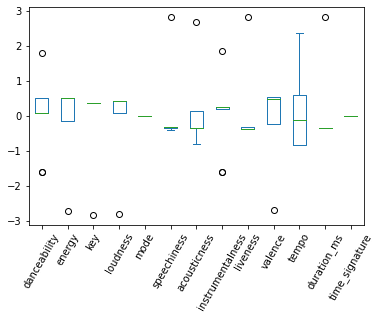

In [32]:
scaled_df.plot(kind='box',rot=60)

Observations<br>
<li>It seems audio values almost fall into within 1 from standard deviation after scaled values.</li>
<li>But we can also observe one outlier in all columns. I guess this outlier is same track but it's recorded in different time such as version remasetered or concert etc. </li>
<li>I want to remove this outlier because I want to use mean value among those duplicated tracks to representation feature values of this specific song. 


In [ ]:
unique_artist_df